## Jupyer Notebook Cobb accident data analysis from 1998-2017 with machine learning using ESRI built-in [Spark](https://spark.apache.org/).

This week, I've been in NY to help daughter to move to a new apartment. In my spare time as I hesitate to run around in NY city because of the Pandemic, I was thinking about doing some meaningful data analysis using ESRI built-in Spark in ArcGIS Pro. I am fascinated with recent year's rise of the data science and the Machine learning approach for many of big data analysis especially applied to Geospatial data. With an abundant data in Cobb County, Cobb traffic and parcel property data are among the big important datasets in my mind to seek something out of it.  Thanks to Mansour mraad's recent [ESRI Spark notebook](https://github.com/mraad),  I did several practices and visualizations using 20 years' Cobb County accident data from 1998-2017.  Rather than having the best solution outright, there are enough leaving room for creativity and innovation in the solution to do the better job. Apache Spark is fast, flexible, and developer-friendly, and the leading platform for large-scale SQL, batch processing, stream processing, and machine learning. In short, the whole idea is about LEARNING, sharing some ideas.

My data has about half milliion records.

For better practice, first:

Create a new conda environment and activate it to use this notebook, as follows:

- Start a `Python Command Prompt` from `Start > ArcGIS`.

- Execute the following:

```
conda create --yes --name spark_esri --clone arcgispro-py3
activate spark_esri
pip install pyarrow
```

### Import the modules and libraries.

In [1]:
import os
import arcpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from python.sparkInit import spark_start, spark_stop
from pyspark.sql.functions import pandas_udf, hour,cos, sin, radians,col
from pyspark.sql.types import DoubleType
%matplotlib inline
fc= r'C:\projects\ESRICrash\CobbDatafgdb.gdb\accidentsReports'

### Start a Spark instance.

Note the `config` argument to [configure the Spark instance](https://spark.apache.org/docs/latest/configuration.html).

In [2]:
config = {"spark.driver.memory":"2G"}
spark = spark_start(config=config)

### Read the accident data feature shapes in WebMercator SR.

The data is stored in a file geoDatabase in local drive. Note that the `SearchCursor` is subject to the user selected features, and to an active query definition in the layer properties. 

In [3]:
sp_ref = arcpy.SpatialReference(3857)
fields=["ACCIDENTDATE","REPORTEDDATE","VEHICLES","INJURED","FATAL","SITE","ROADSURFACE","SEVERITY","WEATHER","DESCRIPTION",
       "CONTROLTYPE","LIGHTCONDITIONS","SHAPE@X","SHAPE@Y"]
data = arcpy.da.SearchCursor(fc,fields)
#data = arcpy.da.SearchCursor(fc,["*"],spatial_reference=sp_ref)

### Create a Spark data frame from the read data, and create a view named 'v0'.

In [4]:
schema=",".join([
    "accident_date timestamp",
    "report_date timestamp",
    "vehicles integer",
    "injured integer",
    "fatal integer",
    "site integer",
    "roadsurface integer",
    "severity integer",
    "weather integer",
    "description integer",
    "controltype integer",
    "lightcondition integer",
    "X double",
    "Y double"
])
spark\
    .createDataFrame(data,schema)\
    .createOrReplaceTempView("v0")

## Data Visualisation and Analysis
### Number of cases in 20 years.
With our data prepared, we can now begin to exploring it to understand the accident patterns. First let's look at 20 year's accident trend with number of cases each year. The cases are very even except a small rise in 2016 which means even though population grows 25% from 566,000 to 753,000, Cobb DOT is doing a very good job to improve roadway and traffic condition. Trafiic accidents in 20 year period in general are fairly homogeneous, has no upward trend.

<Figure size 720x360 with 0 Axes>

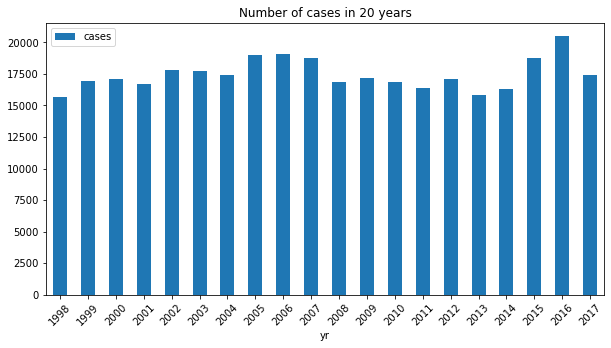

In [5]:
rows = spark\
    .sql(f"""
    select year(accident_date) yr, count(1) cases
    from v0
    where year(accident_date) between 1998 and 2017
    group by yr
    order by yr
    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['yr','cases'])
plt.figure(figsize=(10,5))
plt.clf()
#bar = plt.bar(pdf['yr'],pdf['cases'], label='cases')
pdf.plot(x='yr',y='cases',kind='bar',figsize=[10,5],rot=45)
plt.plot(pdf['yr'],pdf['cases'],'r', label='Cases by year')
plt.title('Number of cases in 20 years')
plt.show()


### Number of cases by months in 20 years
Then 12 monthly accident cases in 20 year period in general are fairly homogeneous, with Winter season has minor bumps of accidents. Maybe winter storm or cold weather has a bit of impact with traffic accidents. 


<Figure size 432x288 with 0 Axes>

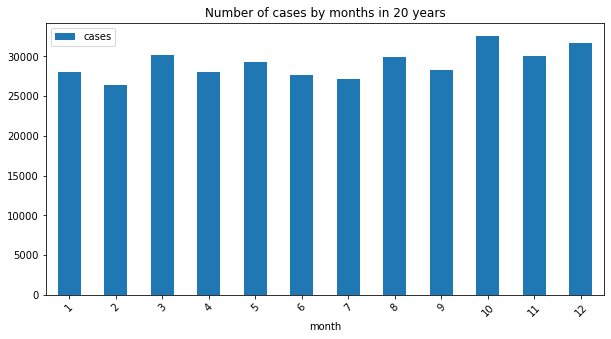

In [6]:
rows = spark\
    .sql(f"""
    select MONTH(accident_date)  month, count(1) cases
    from v0
    where year(accident_date) between 1998 and 2017
    group by MONTH(accident_date)
    order by MONTH
    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['month','cases'])
#plt.figure(figsize=(10,5))
#y_pos=np.arange(len(pdf['month']))
plt.clf()
#bar = plt.bar(pdf['month'],pdf['cases'], label='cases')
pdf.plot(x='month',y='cases',kind='bar',figsize=[10,5],rot=45)
#plt.plot(pdf['month'],pdf['cases'],'r', label='Cases by month')
plt.title('Number of cases by months in 20 years')
plt.show()

### Number of cases by hours in 20 years.
The plot shows accidents are pretty bad during morning rush hours between 7-8 am and afternoon after 3 pm with daily peak around 5 pm to 6pm. Then a gradual decline into late evening 8pm to 6am early morning.

<Figure size 432x288 with 0 Axes>

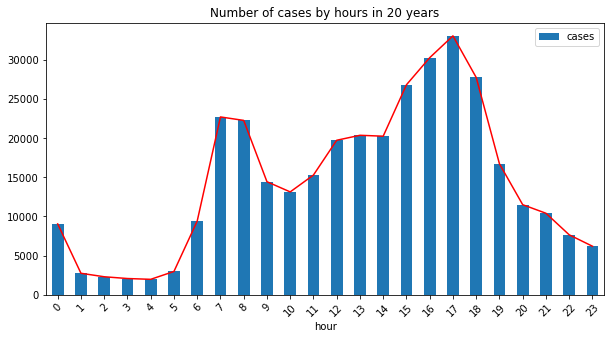

In [7]:
rows = spark\
    .sql(f"""
    select hour(accident_date)  hour, count(1) cases
    from v0
    where year(accident_date) between 1998 and 2017
    group by hour(accident_date)
    order by hour
    """)\
        .collect()
pdf = pd.DataFrame(rows, columns=['hour','cases'])
plt.clf()
pdf.plot(x='hour',y='cases',kind='bar',figsize=[10,5],rot=45)
plt.plot(pdf['hour'],pdf['cases'],'r', label='cases by hours')
plt.title('Number of cases by hours in 20 years')
plt.show()


### Number of cases by day of the week in 20 years.
1-Sunday, 2- Monday, 3-Tuesday, 4-Wedsday, 5-Thursday, 6-Friday, 7-Saturday. The plot shows accidents rise evenly during weekday and decline into weekend. Friday has the bad peak of accidents in the 20 years period.

<Figure size 432x288 with 0 Axes>

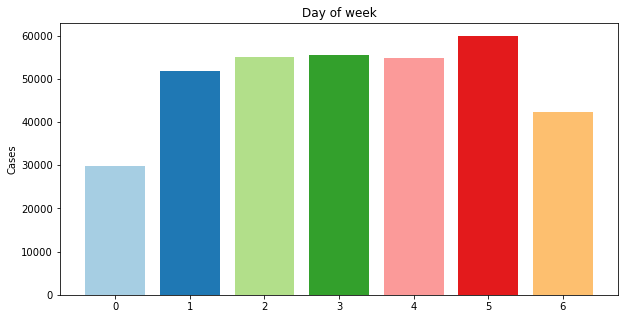

In [8]:
rows = spark\
    .sql(f"""
    select EXTRACT(dayofweek from accident_date)-1 as day_of_week, count(1) cases
    from v0
    where year(accident_date) between 1998 and 2017
    group by EXTRACT(dayofweek from accident_date)
    order by day_of_week

    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['day_of_week','cases'])
plt.clf()
fig=plt.figure(figsize=(10,5))
#ax=fig.add_axes([0,0,10,5])
plt.bar(pdf["day_of_week"],pdf["cases"],color=plt.cm.Paired(pdf["day_of_week"]),figure=fig)
plt.ylabel('Cases')
plt.title("Day of week")
#pdf.plot(x='day_of_week',y='cases',kind='bar', figsize=[10,5])
#ax=pdf.T.plot(kind='bar',label='day_of_week',colormap='Paired')
#ax.set_xlim(0.1,9.5)
#ax.set_xlabel('day of week')
plt.show()


### Cases hourly by day of week in the last 20 years
The weekend (Sun-0 and Sat-6) have lower numbers throughout the day. Weekday follows pretty much the same pattern - early morning rush hours has higher number cases but decline between 10am to early afternoon 2pm and rise to the peak of the day around 5:30pm, which can most likely be attributed to regular traffic pattern of most working people. Then they drop after 5:30pm 

<Figure size 432x288 with 0 Axes>

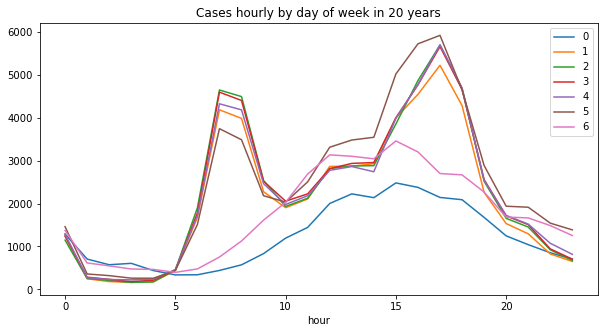

In [9]:
rows = spark\
    .sql(f"""
    select hour(accident_date)  hour, EXTRACT(dayofweek from accident_date) as day_of_week, count(1) cases
    from v0
    where year(accident_date) between 1998 and 2017
    group by hour, day_of_week
    order by hour

    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['hour','day_of_week','cases'])
plt.clf()

_, ax = plt.subplots(figsize=(10,5))
for idx, gp in pdf.groupby('day_of_week'):
    idx=idx-1
    gp.plot(x='hour', y='cases', ax=ax, label=idx)
plt.title('Cases hourly by day of week in 20 years')
plt.show()


### Cases by monthly line graph in the last 20 years


<Figure size 432x288 with 0 Axes>

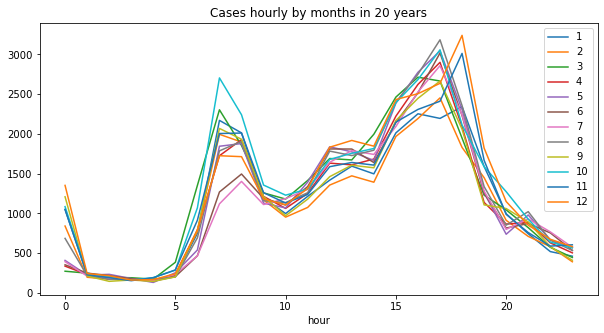

In [10]:
rows = spark\
    .sql(f"""
    select hour(accident_date)  hour, MONTH(accident_date)  month, count(1) cases
    from v0
    where year(accident_date) between 1998 and 2017
    group by hour, month
    order by hour

    """)\
        .collect()
pdf = pd.DataFrame(rows, columns=['hour','month','cases'])
plt.clf()

_, ax = plt.subplots(figsize=(10,5))
for idx, gp in pdf.groupby('month'):
      gp.plot(x='hour', y='cases', ax=ax, label=idx)
plt.title('Cases hourly by months in 20 years')
plt.show()


### Number of fatal cases in 20 years.
The plot shows fatal accidents from 1998 to 2017. It appears 2009 and 2010 both year have the least fatal accidents. We remember during that period, US had an economic crisis and probably lots of people were out of jobs or stay home during that time. In general, there is no notable trends or patterns in the fatal accident graph in the last 20 year period.

<Figure size 432x288 with 0 Axes>

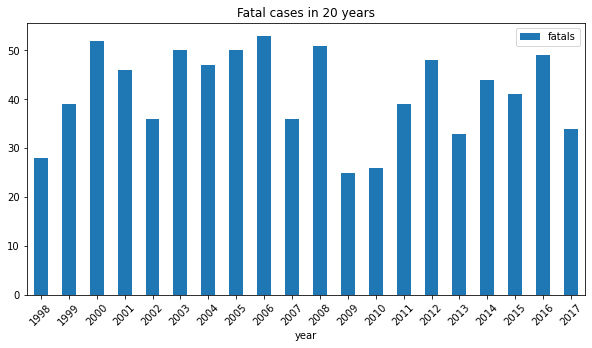

In [11]:
rows = spark\
    .sql(f"""
    select year(accident_date)  year, count(1) fatals
    from v0
    where (year(accident_date) between 1998 and 2017) and (fatal >0)
    group by year(accident_date)
    order by year(accident_date)

    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['year','fatals'])
plt.clf()
pdf.plot(x='year',y='fatals',kind='bar',figsize=[10,5],rot=45)
plt.plot(pdf['year'],pdf['fatals'],'r', label='Fatal cases by year')
plt.title('Fatal cases in 20 years')
plt.show()

### Number of injured cases in 20 years.
The plot shows injured accidents from 1998 to 2017. It appears 2009 and 2010 both year have the least injured accidents which corresponds the fatal graph pattern above. In general, there is slightly upward trend in injured accident data after 2011.

<Figure size 432x288 with 0 Axes>

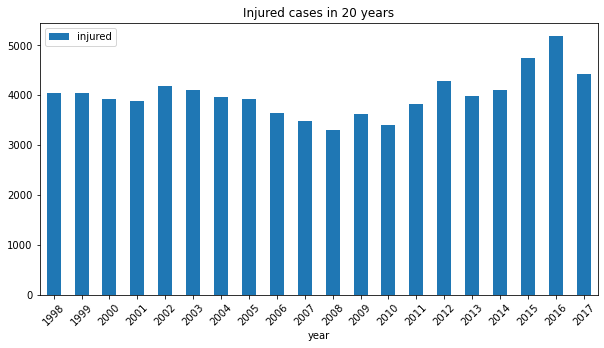

In [35]:
rows = spark\
    .sql(f"""
    select year(accident_date)  year, count(1) injured
    from v0
    where (year(accident_date) between 1998 and 2017) and (injured >0)
    group by year(accident_date)
    order by year(accident_date)

    """)\
        .collect()

pdf = pd.DataFrame(rows, columns=['year','injured'])
plt.clf()
pdf.plot(x='year',y='injured',kind='bar',figsize=[10,5],rot=45)
plt.title('Injured cases in 20 years')
plt.show()

### Create a Spark data frame of the read data, and create a view named 'v1'

In [12]:
sp_ref = arcpy.SpatialReference(3857)
data = arcpy.da.SearchCursor(fc,["SHAPE@X","SHAPE@Y"],spatial_reference=sp_ref)
spark\
    .createDataFrame(data,"x double,y double")\
    .createOrReplaceTempView("v1")

### Let's visualize accidents by aggregate the data at 50x50 meters bins
The aggregation is performed by Spark as a SQL statement in a parallel share-nothing way and the resulting bins are collected back in the rows array variable.

This is a nested SQL expression, where the inner expression is mapping the input x and y into q and r cell locations given a user defined bin size, and the outter expression is aggreating as a sum the q and r pairs. Finally, q and r are mapped back to x and y to enble the placement on a map.


In [13]:
cell0 = 50.0 # meters
cell1 = cell0 * 0.5

rows = spark\
    .sql(f"""
select q*{cell0}+{cell1} x,r*{cell0}+{cell1} y,least(count(1),1000) as ACC
from
(select cast(x/{cell0} as long) q,cast(y/{cell0} as long) r from v1)
group by q,r
""")\
    .collect()

In [14]:
ws = "memory"
nm = "Bins"
fc = os.path.join(ws,nm)
arcpy.management.Delete(fc)
sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws,nm,"POINT",spatial_reference=sp_ref)
arcpy.management.AddField(fc, "ACC", "LONG")

with arcpy.da.InsertCursor(fc, ["SHAPE@X","SHAPE@Y", "ACC"]) as cursor:
    for row in rows:
        cursor.insertRow(row)

### Apply a naturalbreak classification to highlight the bins.
1. first let's look at how accidents happens with spatial spinning map
2. second will apply filter to find those spatial bins that accidents counts are over 200 cases so we need to be focused on these areas. The blue bins show cases over 1000 during 20 year period and really need to do some study.

In [15]:
from arcgis.gis import GIS
#from arcgis.widgets import MapView
gis = GIS()
# load your feature class into a spatially enabled dataframe (sedf)
m_sedf = pd.DataFrame.spatial.from_featureclass(fc)
#m_map

In [16]:
# load your feature class into a spatially enabled dataframe (sedf)
# plot the sedf on your map
m_map1 = gis.map(location = 'Marietta, GA', zoomlevel = 6)
m_sedf.spatial.plot(map_widget = m_map1,
        renderer_type='c',  # for class breaks renderer
        method='esriClassifyNaturalBreaks',  # classification algorithm
        class_count=5,  # choose the number of classes
        col='ACC',  # numeric column to classify
#        cmap='Dark2',  # color map to pick colors from for each class
        cmap='prism',  # color map to pick colors from for each class
        alpha=0.7  # specify opacity
       )
 # show the map
# mapview=MapView(gis=gis, item=m_sedf)
# mapview.legend=True
# mapview
m_map1

MapView(layout=Layout(height='400px', width='100%'))

In [17]:
# over 200 cases with each bin. Those blue color bins have over 1000 cases during 20 years period
m_map = gis.map(location = 'Marietta, GA', zoomlevel = 10)
m_sedfq=m_sedf.copy()
query = m_sedfq['ACC']>200
m_sedfq=m_sedfq[query]

# plot the sedf on your map
m_sedfq.spatial.plot(map_widget = m_map,
        renderer_type='c',  # for class breaks renderer
        method='esriClassifyNaturalBreaks',  # classification algorithm
        class_count=5,  # choose the number of classes
        col='ACC',  # numeric column to classify
        cmap='prism',  # color map to pick colors from for each class
        alpha=0.7  # specify opacity
       )
m_map

MapView(layout=Layout(height='400px', width='100%'))

In [ ]:
# cbs_list = [1]
# cmap_list = []
# class_breaks = m_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
# for cb in class_breaks:
#     print(cb.description, cb.classMaxValue)  # print the class break labels
#     cbs_list.append(cb.classMaxValue)
#     cmap_list.append([x/255.0 for x in cb.symbol.color])


In [ ]:
# # build a histogram for the same class breaks
# n, bins, patches = plt.hist(m_sedf['POP'], bins=cbs_list)

# # apply the same color for each class to match the map
# idx = 0
# for c, p in zip(bins, patches):
#     plt.setp(p, 'facecolor', cmap_list[idx])
#     idx+=1
# plt.title('Histogram of Bin counts')

### Prepare data for machine learning
There are some null geometry points that need to filter out so they are not included in SELECT

In [18]:
pdf = spark\
    .sql(f"""
    select hour(accident_date) hour, site,roadsurface,severity,weather,description,controltype,lightcondition,x,y
    from v0
    where (year(accident_date) between 1990 and 2017) and (x>0 and y>0)
    """)\
    .toPandas()

c:\program files\arcgis\pro\Java\runtime\spark\python\lib\pyspark.zip\pyspark\sql\dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


### Check how many non-null values each column

In [19]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374839 entries, 0 to 374838
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   hour            374839 non-null  int32  
 1   site            374828 non-null  float64
 2   roadsurface     374694 non-null  float64
 3   severity        371568 non-null  float64
 4   weather         100568 non-null  float64
 5   description     374740 non-null  float64
 6   controltype     372346 non-null  float64
 7   lightcondition  374701 non-null  float64
 8   x               374839 non-null  float64
 9   y               374839 non-null  float64
dtypes: float64(9), int32(1)
memory usage: 27.2 MB


### Reclassify severity which assigns "Severe", "killed" and "visualy injured" as severe category "1". Otherwise "0"

In [20]:
pdf.loc[pdf['severity'] == 2.0, 'severity'] = 1
pdf.loc[pdf['severity'] == 3.0, 'severity'] = 1
pdf.loc[pdf['severity'] != 1, 'severity'] = 0

In [21]:
# pdf.insert(8,'hour_rad',np.radians(360.0*pdf['hour']/23.0))
# pdf.insert(9,'hour_cos',np.cos(pdf['hour_rad']))
# pdf.insert(10,'hour_sin',np.sin(pdf['hour_rad']))
## add hour cos and sin to make it cyclic effect. This practice is from Mansour's notebook.
pdf['hour_rad']=np.radians(360.0*pdf['hour']/23.0)
pdf['hour_cos']= np.cos(pdf['hour_rad'])
pdf['hour_sin']= np.sin(pdf['hour_rad'])
pdf['SHAPE@X']=pdf['x']
pdf['SHAPE@Y']=pdf['y']


In [22]:
df = spark.createDataFrame(pdf)
df.printSchema()

c:\program files\arcgis\pro\Java\runtime\spark\python\lib\pyspark.zip\pyspark\sql\session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.


root
 |-- hour: long (nullable = true)
 |-- site: double (nullable = true)
 |-- roadsurface: double (nullable = true)
 |-- severity: double (nullable = true)
 |-- weather: double (nullable = true)
 |-- description: double (nullable = true)
 |-- controltype: double (nullable = true)
 |-- lightcondition: double (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- hour_rad: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- SHAPE@X: double (nullable = true)
 |-- SHAPE@Y: double (nullable = true)



In [23]:
df.head(2)

[Row(hour=13, site=1.0, roadsurface=1.0, severity=0.0, weather=nan, description=7.0, controltype=1.0, lightcondition=1.0, x=2191638.9998000003, y=1461077.3999999985, hour_rad=3.5513656084058534, hour_cos=-0.9172113015054529, hour_sin=-0.39840108984624156, SHAPE@X=2191638.9998000003, SHAPE@Y=1461077.3999999985),
 Row(hour=17, site=1.0, roadsurface=1.0, severity=0.0, weather=nan, description=1.0, controltype=1.0, lightcondition=1.0, x=2189347.2982, y=1399555.6314999983, hour_rad=4.644093487915346, hour_cos=-0.06824241336467135, hour_sin=-0.9976687691905392, SHAPE@X=2189347.2982, SHAPE@Y=1399555.6314999983)]

In [24]:
rows = df.collect()

In [25]:
ws = arcpy.env.scratchGDB  # Forest GP cannot accept memory based ws :-(
nm = "Train"

fields = [f.name for f in df.schema.fields]
fc = os.path.join(ws, nm)

arcpy.management.Delete(fc)

sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws, nm, "POINT", spatial_reference=sp_ref)
for f in fields[:-2]:
    arcpy.management.AddField(fc, f, "DOUBLE")

with arcpy.da.InsertCursor(fc, fields) as cursor:
    for row in rows:
        cursor.insertRow(row)

In [26]:
spark_stop()

### Run Forest Based Regression on the feature class.
I used several variables to run Random forest algorithm to predict accident severity. 

In [37]:
arcpy.env.workspace=ws
arcpy.env.overwriteOutput = True
output = os.path.join(arcpy.env.scratchGDB,"Predictions")

arcpy.gapro.Forest("TRAIN",
                   "Train",
                   output,
                   variable_predict="severity",
                   treat_variable_as_categorical="CATEGORICAL",
                   explanatory_variables="site true;weather true;roadsurface true;lightcondition true;hour_cos false;hour_sin false;x false;y false",
                   number_of_trees=100,
                   minimum_leaf_size=5)

id,value
0,C:\Users\zhangc\AppData\Local\Temp\scratch.gdb\Predictions
1,
2,


### Run success!
I run few problem with no valid data source. Eventually realized it needs to setup first the arcpy workspace. 
The score is not that good as the predicting variable might not ideal for this practice. In reality, this needs to enrich many attribute data for feature engineering. But for now, I am happy to finish the practice.
### Tomorrow I am heading back to GA!